# Tutorial for the bulk montecarlo module of the structural color package

In [1]:
%matplotlib inline
import numpy as np
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import phase_func_sphere as pfs
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.getcwd())

/home/stephenson/Repositories/structural-color


### Parameters to run

In [2]:
# System parameters to vary
microsphere_radius = sc.Quantity(np.array([.5,2.5]),'um') # array of microsphere radii
thickness_bulk = sc.Quantity(np.array([10]),'um') # array of thickness of the bulk film
nanosphere_radius = sc.Quantity(np.array([125]),'nm') # radius of the nanosphere

# Properties of system
ntrajectories = 20000       # number of trajectories for one microsphere
nevents = 500               # number of scattering events in each trajectory in a microsphere
ntrajectories_bulk = 50000  # number of trajectories to run in the bulk film
nevents_bulk = 500          # number of events to run in the bulk film
wavelengths = sc.Quantity(np.arange(400., 801.,10),'nm') # wavelengths at which to calculate reflectance
volume_fraction_microspheres = sc.Quantity(0.55,'') # volume fraction of the microspheres packed in a a nanosphere
volume_fraction_nanospheres = sc.Quantity(0.55,'') # volume fraction of the nanospheres packed in a microsphere

# refractive indices
n_nanoparticle = ri.n('vacuum', wavelengths) # refractive index of nanoparticle
n_matrix = ri.n('fused silica', wavelengths)  # refractive index of matrix
n_medium = ri.n('vacuum', wavelengths)  # refractive index of medium outside the sample.
n_matrix_bulk = n_medium
n_medium_bulk = ri.n('vacuum', wavelengths)
    
# Properties that should not need to be changed
z_low = sc.Quantity('0.0 um')
sns.set_style('white')

### Calculate phase function and reflectances for single microspheres

In [3]:
theta = np.linspace(.01,np.pi,200)
nu = (np.cos(theta)+1)/2
p_microsphere = np.zeros((nanosphere_radius.size, microsphere_radius.size, wavelengths.size, 200))
reflectance_microsphere = np.zeros((nanosphere_radius.size, microsphere_radius.size, wavelengths.size))
lscat = sc.Quantity(np.zeros((nanosphere_radius.size, microsphere_radius.size, wavelengths.size)),'um')
print(lscat[0,0,0])

for k in range(nanosphere_radius.size):
    # print nanoparticle size to keep track of where we are in the calculation
    print('nanoparticle size: ' + str(2*nanosphere_radius[k]))
    for j in range(microsphere_radius.size):
        # print microsphere size to keep track of where we are in the calculation
        print('microsphere size: ' + str(2*microsphere_radius[j]))
        for i in range(wavelengths.size):
            
            # caculate the effective index of the sample
            n_sample = ri.n_eff(n_nanoparticle[i], n_matrix[i], volume_fraction_nanospheres)
            
            # Calculate the phase function and scattering and absorption coefficients from the single scattering model
            # (this absorption coefficient is of the scatterer, not of an absorber added to the system)
            p, mu_scat, mu_abs = mc.calc_scat(nanosphere_radius[k], n_nanoparticle[i], n_sample,
                                              volume_fraction_nanospheres, wavelengths[i])

            # Initialize the trajectories
            r0, k0, W0 = mc.initialize_sphere(nevents, ntrajectories, n_medium[i], n_sample, 
                                              microsphere_radius[j])
            r0 = sc.Quantity(r0, 'um')
            k0 = sc.Quantity(k0, '')
            W0 = sc.Quantity(W0, '')

            # Create trajectories object
            trajectories = mc.Trajectory(r0, k0, W0)

            # Generate a matrix of all the randomly sampled angles first 
            sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

            # Create step size distribution
            step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

            # Run photons
            trajectories.absorb(mu_abs, step)                         
            trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
            trajectories.move(step)

            # Calculate reflection and transmission 
            (refl_indices, trans_indices, 
             k1_refl, k1_trans, 
             norm_refl, norm_trans,
             refl_per_traj, trans_per_traj,
             reflectance_microsphere[k,j,i], transmittance_microsphere)\
                     = mc.calc_refl_trans_sphere(trajectories, n_medium[i], n_sample, microsphere_radius[j], 
                                                 p, mu_abs, mu_scat, plot_exits = False, run_tir = False, return_extra = True)

            # calculate the lscat of the microsphere for use in the bulk simulation
            lscat[k, j, i] = pfs.calc_lscat(refl_per_traj, trans_per_traj, trans_indices, volume_fraction_nanospheres, microsphere_radius[j])
            
            # find the points on the sphere where trajectories exit
            x_inter, y_inter, z_inter = pfs.get_exit_pos(norm_refl, norm_trans, microsphere_radius[j])
    
            # calculate the probability density function as a function of nu, which depends on the scattering angle
            p_microsphere[k,j,i,:] = pfs.calc_pdf(x_inter, y_inter, z_inter, microsphere_radius[j], 
                                                  plot = False, phi_dependent = False)

0.0 micrometer
nanoparticle size: 250 nanometer
microsphere size: 1.0 micrometer


/home/stephenson/anaconda3/lib/python3.5/site-packages/Pint-0.7.2-py3.5.egg/pint/quantity.py:912: RuntimeWarning: invalid value encountered in greater
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: invalid value encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: divide by zero encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:606: RuntimeWarning: invalid value encountered in true_divide
  k1 = k1/mag
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:628: RuntimeWarning: invalid value encountered in true_divide
  dot_z = np.nan_to_num(abs(select_z1-select_z0)/mag)


microsphere size: 5.0 micrometer


### Plot reflectance for single microspheres

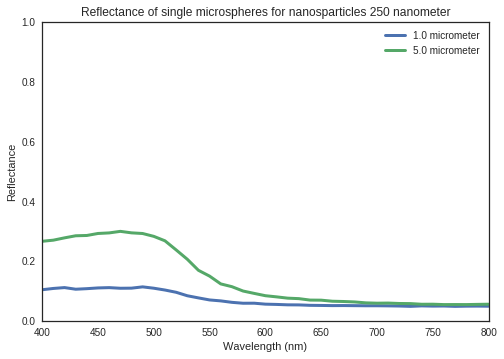

In [4]:
for k in range(nanosphere_radius.size):
    plt.figure()
    plt.title('Reflectance of single microspheres for nanosparticles ' + str(2*nanosphere_radius[k]))
    for j in range(microsphere_radius.size):
        plt.plot(wavelengths, reflectance_microsphere[k,j,:], linewidth = 3, label = str(2*microsphere_radius[j]))

    plt.legend()
    plt.ylim([0,1])
    plt.xlim([400,800])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.savefig('bulk_figs/reflectance_1sphere_particle' + str(2*nanosphere_radius[k].magnitude) + '.pdf')

### Calculate reflectance for bulk film of structurally colored microspheres

There are two key differences between the bulk Monte Carlo simulation and a typical Monte Carlo simulation

1. Trajectory 1st step direction
In the bulk film, trajectories do not propagate forward one step before scattering. Instead they enter the sample at an angle sampled from the the structured sphere phase function. We chose not to propagate them forward by 1 step first because the 1 step forward propagation is already accounted for in the monte carlo run inside the structured sphere.  

2. Scattering length
In the bulk film, the scattering length is not sampled from a distribution, but is instead is assumed to be the interparticle spacing calculated from the diameter and volume fraction of the structured spheres.
It is unclear whether this is the ideal scattering length to use, so this may be updated in future versions.


In [5]:
reflectance_bulk = np.zeros((thickness_bulk.size, nanosphere_radius.size, microsphere_radius.size, wavelengths.size))

for k in range(thickness_bulk.size):
    print('bulk_thickness: ' + str(thickness_bulk[k]))
    for l in range(nanosphere_radius.size):
        print('nanoparticle size: ' + str(2*nanosphere_radius[l]))
        for j in range(microsphere_radius.size):
            print('microsphere size: ' + str(2*microsphere_radius[j]))
            if microsphere_radius[j] > thickness_bulk[k]:
                continue
            for i in range(wavelengths.size):

                #p = np.load('phase_function_data.npy')

                # Initialize the trajectories
                r0, k0, W0 = mc.initialize(nevents_bulk, ntrajectories_bulk, n_medium_bulk[i], n_matrix_bulk[i])
                r0 = sc.Quantity(r0, 'um')
                W0 = sc.Quantity(W0, '')

                # Sample angles
                sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents_bulk, ntrajectories_bulk, p_microsphere[l,j,i,:])

                # Calculate step size
                d_avg = pfs.calc_d_avg(volume_fraction_microspheres, microsphere_radius[j])
                step = d_avg*np.ones((nevents_bulk,ntrajectories_bulk))
                step = lscat[l, j, i]*np.ones((nevents_bulk,ntrajectories_bulk))

                # initialize first direction to be the last sampled angle 
                # (since last sample angle isn't used, this is equivalent to sampling another angle)
                k0[0,0,:] = sintheta[-1,:]*cosphi[-1,:]
                k0[1,0,:] = sintheta[-1,:]*sinphi[-1,:]
                k0[2,0,:] = costheta[-1,:]
                k0 = sc.Quantity(k0, '')
                
                # Create trajectories object
                trajectories = mc.Trajectory(r0, k0, W0)

                # Run photons
                #trajectories.absorb(mu_abs, step)                         
                trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
                trajectories.move(step)

                # calculate reflectance
                reflectance_bulk[k, l, j, i], transmittance = mc.calc_refl_trans(trajectories, z_low, thickness_bulk[k],
                                                                              n_medium_bulk[i], n_matrix_bulk[i])

bulk_thickness: 10 micrometer
nanoparticle size: 250 nanometer
microsphere size: 1.0 micrometer
microsphere size: 5.0 micrometer


### Plot reflectances of bulk films

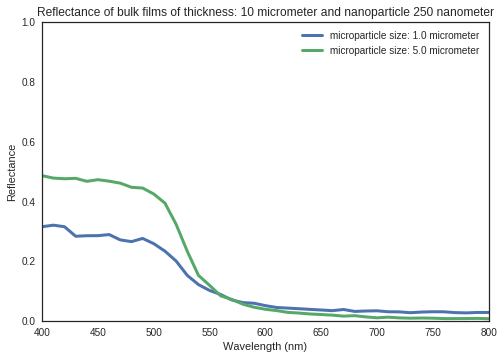

In [6]:
plt.figure()
for l in range(nanosphere_radius.size):
    for k in range(thickness_bulk.size):
        plt.figure()
        for j in range(microsphere_radius.size):
            plt.plot(wavelengths, reflectance_bulk[k, l ,j,:], linewidth = 3, label = 'microparticle size: '+ str(2*microsphere_radius[j]))

        plt.legend()
        plt.ylim([0,1])
        plt.xlim([400,800])
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance')
        plt.title('Reflectance of bulk films of thickness: ' + str(thickness_bulk[k]) + ' and nanoparticle ' + str(2*nanosphere_radius[l]))
        plt.savefig('bulk_figs/reflectance_bulk_' + str(thickness_bulk[k].magnitude) + '_' + str(2*nanosphere_radius[l]) + 'particle.pdf')

In [7]:
# save

# np.save('bulk_figs/reflectance1sphere', reflectance_microsphere)
np.save('bulk_figs/reflectance_bulk_lscat', reflectance_bulk)